In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd
import xarray as xr
import glob
import utils
import faceted
import scipy.stats as stats

In [2]:
utils.set_plot_configs(plt, fsize=8)

In [3]:
results_dir = utils.get_path('results')
datasets_dir = utils.get_path('datasets')

In [15]:
ds_net_zero = xr.open_mfdataset(results_dir+"/fair/ssp*all_net-zero-zec.nc")
ds_hist = xr.open_mfdataset(results_dir+"/fair/historical_all_2024-zec.nc")

In [16]:
ds = xr.concat([ds_hist, ds_net_zero], dim="scenario")

In [17]:
sample_range = np.linspace(-1, 1, 1000)

kde_results = {}

ZEC_div_Tze_results = []

# Iterate over each scenario
for scenario in ds.scenario:

    Tze = ds.temperature.sel(timebound=utils.get_net_zero_GHG_time(scenario.item())-.5,
                             scenario=scenario).isel(layer=0)
    Tf = ds.temperature.sel(timebound=3000, scenario=scenario).isel(layer=0)
    ZEC_div_Tze = (Tf - Tze)/Tze
    
    # Compute KDE for the current scenario
    kde = stats.gaussian_kde(ZEC_div_Tze.values, bw_method="silverman")
    
    # Evaluate the KDE on the sample range
    kde_data = kde.evaluate(sample_range)
    
    # Store the result in the dictionary (or another xarray if preferred)
    kde_results[scenario.values.item()] = kde_data
    ZEC_div_Tze_results.append(ZEC_div_Tze.drop_vars("timebound"))
    
kde_xarray = xr.DataArray(
    np.array(list(kde_results.values())), 
    coords=[list(kde_results.keys()), sample_range], 
    dims=["scenario", "sample_range"]
)

ZEC_div_Tze = xr.concat(ZEC_div_Tze_results, dim="scenario")

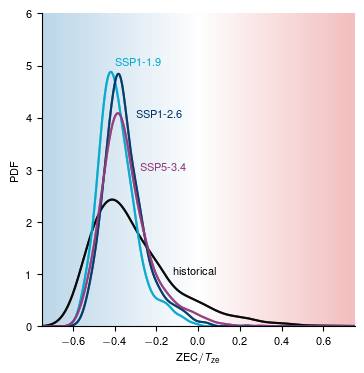

In [64]:
# Define your figure and axis sizes
figheight = 3
figwidth = 7
hspace = .1
wspace = .2

markersize = 20
markershape = "D"
linewidth=1.5

fig, (axis,) = faceted.faceted(1,1,sharex=True,width=3.5, aspect=1.0, sharey=False, left_pad=.35,
                              bottom_pad=.4, right_pad=.02, top_pad=.05)

# Right-hand plot (now ax0): KDE plot
for scenario in kde_xarray.scenario:
    axis.plot(sample_range, kde_xarray.sel(scenario=scenario), color=utils.get_color(scenario.item()),
             linewidth=linewidth, alpha=.8)

    axis.plot(sample_range, kde_xarray.sel(scenario=scenario), color=utils.get_color(scenario.item()),
             linewidth=linewidth, alpha=.8)
    
axis.set_xlim([-.75, .75])
axis.set_ylim([0, 6])
axis.set_xlabel(r"$\text{ZEC}/T_\text{ze}$")
axis.set_ylabel(r"PDF")
axis.spines['right'].set_visible(False)
axis.spines['top'].set_visible(False)

# color gradient 
gradient = np.linspace(-0.75, 0.25, 100)  # X-axis gradient
gradient = np.tile(gradient, (100, 1))  # Create a 2D gradient for background
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["#1f77b4", "white", "#d62728"])
axis.imshow(gradient, aspect='auto', extent=[-0.75, 0.75, 0, 6], origin='lower', cmap=cmap, alpha=0.3)

axis.text(-0.28, 3, "SSP5-3.4", color=utils.get_color("ssp534-over"))
axis.text(-.3, 4, "SSP1-2.6", color=utils.get_color("ssp126"))
axis.text(-.4, 5, "SSP1-1.9", color=utils.get_color("ssp119"))
axis.text(-0.12, 1, "historical", color="black")

fig.savefig(results_dir+"/figures/fig_4.pdf")